In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, Ridge
# evaluate knn on  with k-means ordinal discretization transform
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
import time

In [3]:
heart = pd.read_csv('dataset/heart.csv')
#heart2 = pd.read_csv('dataset/heart_failure_clinical_records_dataset.csv')

In [4]:
dataset = heart

In [5]:
dataset.drop_duplicates(inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [6]:
dataset

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
2     41    0   1     130   204    0        0       172     0      1.4    2   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
297   57    0   0     140   241    0        1       123     1      0.2    1   
298   45    1   3     110   264    0        1       132     0      1.2    1   
299   68    1   0     144   193    1        1       141     0      3.4    1   
300   57    1   0     130   131    0        1       115     1      1.2    1   
301   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thall  output  
0      0      1       1  
1      0      2       1  
2      0      2       1  
3      0      2       1  
4      0      2       1  
..   ...    ...     ...  
297    0      3       0  
298    0      3       0  
299    2      3       0  
300    1      3       0  
301    1      2       0  

[302 rows x 14 columns]

In [7]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

In [8]:
#Standerdize
def standardise(X):
    scaler = StandardScaler()
    scaler.fit(X)
    scaled_features = scaler.transform(X) # centering and scaling
    return(scaled_features)

In [9]:
## Train the Adaboost Classifier

## Train the Support Vector Classifier

In [10]:
def calculate_model(param,X,y):
    
    recall_list_10 = []
    precision_list_10 = []
    specificity_10 = []
    f1_list_10 = []
    accuracy_10 = []
    cpu_10 = []
    roc_10 = []
    

    kfold = KFold(n_splits=10, shuffle=True)
    for i in range(30):
        recall_list = []
        precision_list = []
        specificity = []
        f1_list = []
        accuracy = []
        cpu = []
        roc_list = []
        



        for train_ix, test_ix in kfold.split(X, y):




            X_train , X_test = X[train_ix],X[test_ix]
            y_train , y_test = y[train_ix] , y[test_ix]
            
            t0= time.time()
            if (param == 0):
                model = AdaBoostClassifier()
                
            else:
                model = AdaBoostClassifier(n_estimators=param['clf__n_estimators'], base_estimator=param['clf__base_estimator'],algorithm='SAMME.R',
                                           learning_rate=param['clf__learning_rate'])
                

          

            model.fit(X_train,y_train)
            predictions = model.predict(X_test)
            probs = model.predict_proba(X_test)
            probs = probs[:, 1]
            t1 = time.time() - t0
                        #print("Time elapsed: ", t1) # CPU seconds elapsed (floating point)
            cm = confusion_matrix(y_test,predictions)
            f1_list.append(f1_score(y_test, predictions, average="weighted")*100)

            recall_list.append(recall_score(y_test, predictions, average="weighted")*100)
            precision_list.append(precision_score(y_test, predictions, average="weighted")*100)
            specificity1 = cm[1,1]/(cm[0,1]+cm[1,1])
            if not np.isnan(specificity1):
                specificity.append( (cm[1,1]/(cm[0,1]+cm[1,1]))*100)
            accuracy.append(accuracy_score(y_test, predictions)*100)
            roc_list.append(roc_auc_score(y_test, probs)*100)
            cpu.append(t1)

        precision_list_10.append(sum(precision_list)/10)
        specificity_10.append(sum(specificity)/len(specificity))
        f1_list_10.append(sum(f1_list)/10)
        accuracy_10.append(sum(accuracy)/10)
        recall_list_10.append(sum(recall_list)/10)
        roc_10.append(sum(roc_list)/10)
        cpu_10.append(sum(cpu)/10)


    plt.figure(figsize=(10,6))
    plt.plot(range(0,30),accuracy_10,color='blue', linestyle='dashed', 
             marker='o',markerfacecolor='red', markersize=10)
    plt.title('checking the variance in 30 iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.show()
   
    accu = sum(accuracy_10)/30
    pre = sum(precision_list_10)/30
    spec = sum(specificity_10)/30
    rec =  sum(recall_list_10)/30
    f1 =  sum(f1_list_10)/30
    roc = sum(roc_10)/30
    cpu = sum(cpu_10)/30
    return([accu,pre,spec,rec,f1,roc,cpu])



##  Grid serach 

In [11]:
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
def grid_search():
    clf = Pipeline([('clf', AdaBoostClassifier())])
    
    parameters = {
        'clf__base_estimator': [RandomForestClassifier(),DecisionTreeClassifier(),SVC(probability=True, kernel='linear')],
        'clf__n_estimators': [20, 50, 70, 100],
        'clf__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
        }

    
    gs_clf = GridSearchCV(clf, parameters, cv=10, n_jobs=-1)
    gs_clf = gs_clf.fit(X_train,y_train)
    print("Best score accurracy = %.3f%%" %((gs_clf.best_score_)*100.0))
    print("Best parameters are : ")
    print(gs_clf.best_params_)
    return(gs_clf.best_params_)



In [12]:
dict_Adaboost = {}

## First Model without preprocessing 

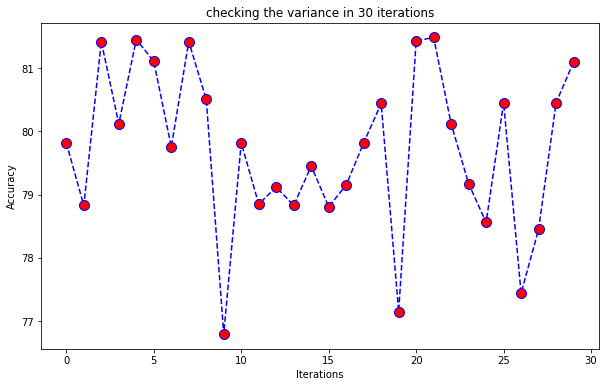

{'Ada': [79.71003584229392,
  80.86812184407745,
  80.29683958353057,
  79.71003584229392,
  79.63439585244504,
  86.44858714102801,
  0.09087952534357707]}

In [12]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

#from collections import defaultdict
scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = 0
X=scaled_features
result = calculate_model(param,X,y)
    
dict_Adaboost['Ada'] = result
dict_Adaboost


## Hypertune model using grid search

In [13]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)

param = grid_search()
#print(param)
X=scaled_features
result = calculate_model(param,X,y)
dict_Adaboost['Hypertuned'] = result
dict_Adaboost

Best score accurracy = 84.233%
Best parameters are : 
{'clf__base_estimator': SVC(kernel='linear', probability=True), 'clf__learning_rate': 0.01, 'clf__n_estimators': 50}


{'Ada': [79.71003584229392,
  80.86812184407745,
  80.29683958353057,
  79.71003584229392,
  79.63439585244504,
  86.44858714102801,
  0.09087952534357707],
 'Hypertuned': [82.92437275985661,
  84.11820605924869,
  81.33342785587702,
  82.92437275985661,
  82.79063579843724,
  90.59764345851258,
  0.698605844179789]}

## PCA

In [14]:
from sklearn.decomposition import PCA
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values
pca = PCA(n_components= 5)
pca.fit(scaled_features)
x_pca = pca.transform(scaled_features)

In [15]:
pca.explained_variance_ratio_

array([0.21313479, 0.11859478, 0.09359819, 0.09121102, 0.07870341])

In [16]:
df_comp = pd.DataFrame(pca.components_,columns=dataset.iloc[:, 0:-1].columns)

<AxesSubplot:>

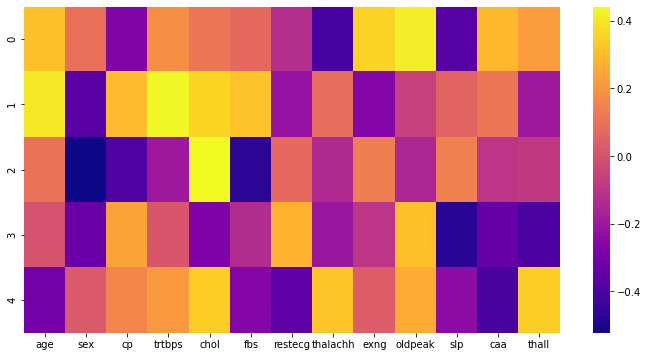

In [17]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

Best score accurracy = 83.817%
Best parameters are : 
{'clf__base_estimator': SVC(kernel='linear', probability=True), 'clf__learning_rate': 0.0001, 'clf__n_estimators': 50}


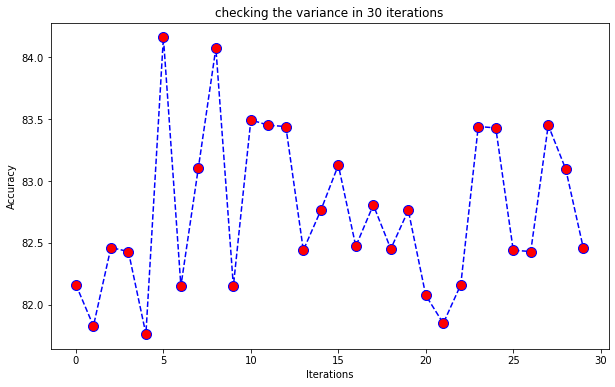

In [18]:
X = x_pca
y = dataset.iloc[:, -1].values
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, random_state=401)
param = grid_search()

result = calculate_model(param,X,y)
dict_Adaboost['Pca'] = result


In [19]:
result

[82.74480286738351,
 83.78789791498035,
 81.6479959345456,
 82.74480286738351,
 82.62326776161487,
 90.78437620752423,
 0.6756886172294619]

## Chi square 

In [20]:
from sklearn.feature_selection import chi2
X = dataset.iloc[:, 0:-1]
#X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, random_state=401
                                                   )


f_p_values=chi2(X_train,y_train)
f_p_values
import pandas as pd
p_values=pd.Series(f_p_values[1])
p_values.index=X_train.columns
p_values

p_values.sort_values(ascending=True)

thalachh    3.573489e-29
oldpeak     4.988046e-14
cp          4.560070e-13
caa         7.416428e-12
exng        1.118408e-07
chol        3.937952e-05
trtbps      9.218368e-04
age         2.513967e-03
sex         5.706724e-03
slp         1.422821e-02
thall       2.918080e-02
restecg     1.844659e-01
fbs         6.602866e-01
dtype: float64

In [21]:
X = dataset[['caa','thalachh','oldpeak','exng','cp','chol','trtbps','age','sex']].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)
X = scaled_features
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, random_state=401
                                                   )

param = grid_search()

result = calculate_model(param,X,y)
dict_Adaboost['Chi'] = result


Best score accurracy = 82.583%
Best parameters are : 
{'clf__base_estimator': RandomForestClassifier(), 'clf__learning_rate': 0.3, 'clf__n_estimators': 20}


In [22]:
dict_Adaboost

{'Ada': [79.71003584229392,
  80.86812184407745,
  80.29683958353057,
  79.71003584229392,
  79.63439585244504,
  86.44858714102801,
  0.09087952534357707],
 'Hypertuned': [82.92437275985661,
  84.11820605924869,
  81.33342785587702,
  82.92437275985661,
  82.79063579843724,
  90.59764345851258,
  0.698605844179789],
 'Pca': [82.74480286738351,
  83.78789791498035,
  81.6479959345456,
  82.74480286738351,
  82.62326776161487,
  90.78437620752423,
  0.6756886172294619],
 'Chi': [80.95089605734766,
  81.94130806059597,
  80.61688147425626,
  80.95089605734766,
  80.821072381,
  88.62366381521056,
  0.15476181666056316]}

## discritizer 

In [23]:
categorical_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
numerical_cols = ["age","trtbps","chol","thalachh","oldpeak"]
target_col = ["output"]
from sklearn.preprocessing import KBinsDiscretizer
trans = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
#trans = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
#trans = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
data = trans.fit_transform(dataset[numerical_cols])
# convert the array back to a dataframe
num_cols = pd.DataFrame(data, dtype = 'int')
#num_cols = pd.DataFrame(data)
num_cols
num_cols.rename(columns = {0:'age', 1:'trtbps',2:'chol',3:'thalachh',4:'oldpeak'}, inplace = True)
df_add = dataset[categorical_cols].add(num_cols,fill_value=0)
df_add = pd.DataFrame(df_add, dtype = int)
df_add

age  caa  chol  cp  exng  fbs  oldpeak  restecg  sex  slp  thalachh  \
0      7    0     2   3     0    1        3        0    1    0         6   
1      1    0     2   2     0    0        5        1    1    0         8   
2      2    0     1   1     0    0        2        0    0    2         7   
3      5    0     2   1     0    0        1        1    1    2         8   
4      5    0     5   0     1    0        0        1    0    2         7   
..   ...  ...   ...  ..   ...  ...      ...      ...  ...  ...       ...   
297    5    0     2   0     1    0        0        1    0    1         3   
298    3    0     3   3     0    0        1        1    1    1         4   
299    8    2     1   0     0    1        5        1    1    1         5   
300    5    1     0   0     1    0        1        1    1    1         3   
301    5    1     2   1     0    0        0        0    0    1         7   

     thall  trtbps  
0        1       4  
1        2       3  
2        2       3  
3        2       2  
4        2       2  
..     ...     ...  
297      3       4  
298      3       1  
299      3       4  
300      3       3  
301      2       3  

[302 rows x 13 columns]

Best score accurracy = 83.817%
Best parameters are : 
{'clf__base_estimator': SVC(kernel='linear', probability=True), 'clf__learning_rate': 0.001, 'clf__n_estimators': 50}


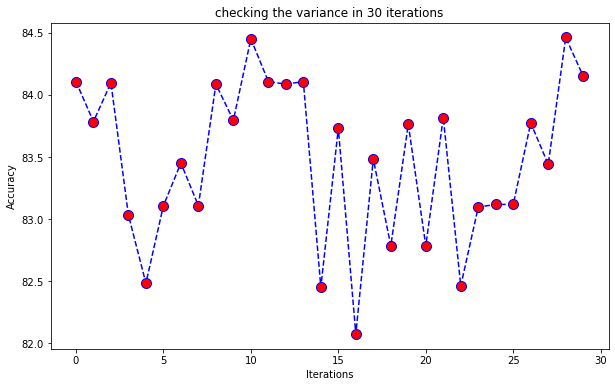

In [24]:
X = df_add.iloc[::].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)
X = scaled_features
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, random_state=401
                                                   )

param = grid_search()

result = calculate_model(param,X,y)
dict_Adaboost['Discrete'] = result


In [25]:
dict_Adaboost

{'Ada': [79.71003584229392,
  80.86812184407745,
  80.29683958353057,
  79.71003584229392,
  79.63439585244504,
  86.44858714102801,
  0.09087952534357707],
 'Hypertuned': [82.92437275985661,
  84.11820605924869,
  81.33342785587702,
  82.92437275985661,
  82.79063579843724,
  90.59764345851258,
  0.698605844179789],
 'Pca': [82.74480286738351,
  83.78789791498035,
  81.6479959345456,
  82.74480286738351,
  82.62326776161487,
  90.78437620752423,
  0.6756886172294619],
 'Chi': [80.95089605734766,
  81.94130806059597,
  80.61688147425626,
  80.95089605734766,
  80.821072381,
  88.62366381521056,
  0.15476181666056316],
 'Discrete': [83.4774193548387,
  84.706394767226,
  81.82465290238643,
  83.4774193548387,
  83.3234272945779,
  90.2601257235508,
  0.6023255332310993]}

## Discritization(uniform) + Chi

In [28]:
X =  df_add
y = dataset.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=401)

f_p_values=chi2(X_train,y_train)
f_p_values
import pandas as pd
p_values=pd.Series(f_p_values[1])
p_values.index=X.columns
p_values

p_values.sort_values(ascending=True)

oldpeak     4.853053e-23
cp          4.560070e-13
caa         7.416428e-12
exng        1.118408e-07
thalachh    1.023415e-05
sex         5.706724e-03
slp         1.422821e-02
thall       2.918080e-02
age         3.413408e-02
trtbps      4.439132e-02
restecg     1.844659e-01
chol        4.203979e-01
fbs         6.602866e-01
dtype: float64

In [29]:
X = df_add[['caa','slp','thalachh','thall','oldpeak','exng','cp','sex','age']].values
y = dataset.iloc[:, -1].values
scaled_features = standardise(X)

X=scaled_features
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, random_state=401
                                                   )

param = grid_search()

result = calculate_model(param,X,y)
dict_Adaboost['Discrete+Chi'] = result


Best score accurracy = 83.400%
Best parameters are : 
{'clf__base_estimator': SVC(kernel='linear', probability=True), 'clf__learning_rate': 0.01, 'clf__n_estimators': 50}


In [30]:
dict_Adaboost

{'Ada': [79.71003584229392,
  80.86812184407745,
  80.29683958353057,
  79.71003584229392,
  79.63439585244504,
  86.44858714102801,
  0.09087952534357707],
 'Hypertuned': [82.92437275985661,
  84.11820605924869,
  81.33342785587702,
  82.92437275985661,
  82.79063579843724,
  90.59764345851258,
  0.698605844179789],
 'Pca': [82.74480286738351,
  83.78789791498035,
  81.6479959345456,
  82.74480286738351,
  82.62326776161487,
  90.78437620752423,
  0.6756886172294619],
 'Chi': [80.95089605734766,
  81.94130806059597,
  80.61688147425626,
  80.95089605734766,
  80.821072381,
  88.62366381521056,
  0.15476181666056316],
 'Discrete': [83.4774193548387,
  84.706394767226,
  81.82465290238643,
  83.4774193548387,
  83.3234272945779,
  90.2601257235508,
  0.6023255332310993],
 'Discrete+Chi': [83.84408602150538,
  85.01110725878925,
  82.58025168646381,
  83.84408602150538,
  83.70149160599347,
  90.48533206076723,
  0.6693462856610617]}

## Mutual Info 

In [31]:
from sklearn.feature_selection import mutual_info_classif
X = dataset.iloc[:, 0:-1]
#X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1]
scaled_features = standardise(X)
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(scaled_features,y,
                                                    test_size=0.2, random_state=401
                                                   )
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([0.00108705, 0.        , 0.20131142, 0.        , 0.07178271,
       0.        , 0.02590327, 0.05730731, 0.08856068, 0.04364939,
       0.11517771, 0.06266441, 0.13004525])

In [32]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

cp          0.201311
thall       0.130045
slp         0.115178
exng        0.088561
chol        0.071783
caa         0.062664
thalachh    0.057307
oldpeak     0.043649
restecg     0.025903
age         0.001087
fbs         0.000000
trtbps      0.000000
sex         0.000000
dtype: float64

Best score accurracy = 82.583%
Best parameters are : 
{'clf__base_estimator': SVC(kernel='linear', probability=True), 'clf__learning_rate': 0.2, 'clf__n_estimators': 20}


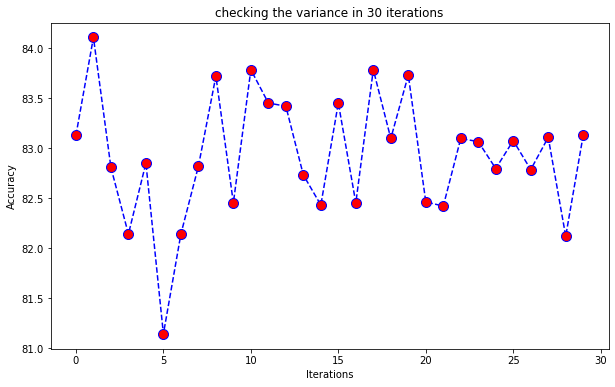

In [33]:
X = dataset[['oldpeak','thall','exng','cp','chol','caa','thalachh']].values
y = dataset.iloc[:, -1].values

X= standardise(X)   
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, random_state=401
                                                   )

param = grid_search()

result = calculate_model(param,X,y)
dict_Adaboost['MI'] = result


In [34]:
dict_Adaboost

{'Ada': [79.71003584229392,
  80.86812184407745,
  80.29683958353057,
  79.71003584229392,
  79.63439585244504,
  86.44858714102801,
  0.09087952534357707],
 'Hypertuned': [82.92437275985661,
  84.11820605924869,
  81.33342785587702,
  82.92437275985661,
  82.79063579843724,
  90.59764345851258,
  0.698605844179789],
 'Pca': [82.74480286738351,
  83.78789791498035,
  81.6479959345456,
  82.74480286738351,
  82.62326776161487,
  90.78437620752423,
  0.6756886172294619],
 'Chi': [80.95089605734766,
  81.94130806059597,
  80.61688147425626,
  80.95089605734766,
  80.821072381,
  88.62366381521056,
  0.15476181666056316],
 'Discrete': [83.4774193548387,
  84.706394767226,
  81.82465290238643,
  83.4774193548387,
  83.3234272945779,
  90.2601257235508,
  0.6023255332310993],
 'Discrete+Chi': [83.84408602150538,
  85.01110725878925,
  82.58025168646381,
  83.84408602150538,
  83.70149160599347,
  90.48533206076723,
  0.6693462856610617],
 'MI': [82.92293906810035,
  84.56105302329674,
  80.2

## Sequential Forward Selection

In [41]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)
svc =  LogisticRegression()
sfs = SFS(svc, 
          k_features=8, 
          forward=True, 
          floating=False, 
          scoring='accuracy',

          n_jobs=-1)
sfs = sfs.fit(X_train, y_train)

print('\nSequential Forward Selection (k=3):')
print(sfs.k_feature_idx_)
print(sfs.k_feature_names_)
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection (k=3):
(1, 2, 4, 6, 7, 9, 11, 12)
('1', '2', '4', '6', '7', '9', '11', '12')
CV Score:
0.8422619047619048


In [42]:
feat_cols = list(sfs.k_feature_idx_)
feat_cols
X_train = X_train[:, feat_cols]
X_test = X_test[:, feat_cols]
X=scaled_features
X = X[:,feat_cols]
param =  grid_search()
result = calculate_model(param,X,y)
dict_Adaboost['SFS'] = result


Best score accurracy = 84.233%
Best parameters are : 
{'clf__base_estimator': SVC(kernel='linear', probability=True), 'clf__learning_rate': 0.01, 'clf__n_estimators': 70}


In [37]:
dict_Adaboost

{'Ada': [79.71003584229392,
  80.86812184407745,
  80.29683958353057,
  79.71003584229392,
  79.63439585244504,
  86.44858714102801,
  0.09087952534357707],
 'Hypertuned': [82.92437275985661,
  84.11820605924869,
  81.33342785587702,
  82.92437275985661,
  82.79063579843724,
  90.59764345851258,
  0.698605844179789],
 'Pca': [82.74480286738351,
  83.78789791498035,
  81.6479959345456,
  82.74480286738351,
  82.62326776161487,
  90.78437620752423,
  0.6756886172294619],
 'Chi': [80.95089605734766,
  81.94130806059597,
  80.61688147425626,
  80.95089605734766,
  80.821072381,
  88.62366381521056,
  0.15476181666056316],
 'Discrete': [83.4774193548387,
  84.706394767226,
  81.82465290238643,
  83.4774193548387,
  83.3234272945779,
  90.2601257235508,
  0.6023255332310993],
 'Discrete+Chi': [83.84408602150538,
  85.01110725878925,
  82.58025168646381,
  83.84408602150538,
  83.70149160599347,
  90.48533206076723,
  0.6693462856610617],
 'MI': [82.92293906810035,
  84.56105302329674,
  80.2

## Sequential  backward search 

In [16]:

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

scaled_features = standardise(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=401)
svc =  LogisticRegression()
sfs = SFS(svc, 
          k_features=7, 
          forward=False, 
          floating=False, 
          scoring='accuracy',

          n_jobs=-1)
sfs = sfs.fit(X_train, y_train)

print('\nSequential Forward Selection (k=3):')
print(sfs.k_feature_idx_)
print(sfs.k_feature_names_)
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection (k=3):
(1, 2, 3, 9, 10, 11, 12)
('1', '2', '3', '9', '10', '11', '12')
CV Score:
0.8423469387755101


In [17]:
feat_cols = list(sfs.k_feature_idx_)
feat_cols
X_train = X_train[:, feat_cols]
X_test = X_test[:, feat_cols]
X=scaled_features
X = X[:,feat_cols]
param =  grid_search()
result = calculate_model(param,X,y)
dict_Adaboost['SBS'] = result


Best score accurracy = 85.467%
Best parameters are : 
{'clf__base_estimator': SVC(kernel='linear', probability=True), 'clf__learning_rate': 0.0001, 'clf__n_estimators': 20}


In [45]:
df_dict = pd.DataFrame.from_dict(dict_Adaboost,orient='index', columns= ['Accuracy','Precision','Specificity','Recall','F1_score','Roc','CPU_time'])
df_dict

Accuracy  Precision  Specificity     Recall   F1_score  \
Ada           79.710036  80.868122    80.296840  79.710036  79.634396   
Hypertuned    82.924373  84.118206    81.333428  82.924373  82.790636   
Pca           82.744803  83.787898    81.647996  82.744803  82.623268   
Chi           80.950896  81.941308    80.616881  80.950896  80.821072   
Discrete      83.477419  84.706395    81.824653  83.477419  83.323427   
Discrete+Chi  83.844086  85.011107    82.580252  83.844086  83.701492   
MI            82.922939  84.561053    80.214589  82.922939  82.699176   
SFS           84.294982  85.234869    84.429658  84.294982  84.249853   
SBS           84.129032  85.162442    84.112230  84.129032  84.077314   

                    Roc  CPU_time  
Ada           86.448587  0.090880  
Hypertuned    90.597643  0.698606  
Pca           90.784376  0.675689  
Chi           88.623664  0.154762  
Discrete      90.260126  0.602326  
Discrete+Chi  90.485332  0.669346  
MI            88.772925  0.254039  
SFS           90.059236  0.878502  
SBS           90.014327  0.648593

In [46]:
#df_dict.to_excel('xl_result/Adaboost_heart1_30.xlsx')

In [19]:
#df_dict =  pd.read_excel('xl_result/Adaboost_heart1_30.xlsx',index_col=0)

In [20]:
# Adding Number of features
df_dict['no_of_features'] = [13,13,'5componenets',9,13,9,7,8,7]
df_dict

Accuracy  Precision  Specificity     Recall   F1_score  \
Ada           79.710036  80.868122    80.296840  79.710036  79.634396   
Hypertuned    82.924373  84.118206    81.333428  82.924373  82.790636   
Pca           82.744803  83.787898    81.647996  82.744803  82.623268   
Chi           80.950896  81.941308    80.616881  80.950896  80.821072   
Discrete      83.477419  84.706395    81.824653  83.477419  83.323427   
Discrete+Chi  83.844086  85.011107    82.580252  83.844086  83.701492   
MI            82.922939  84.561053    80.214589  82.922939  82.699176   
SFS           84.294982  85.234869    84.429658  84.294982  84.249853   
SBS           84.129032  85.162442    84.112230  84.129032  84.077314   

                    Roc  CPU_time no_of_features  
Ada           86.448587  0.090880             13  
Hypertuned    90.597643  0.698606             13  
Pca           90.784376  0.675689   5componenets  
Chi           88.623664  0.154762              9  
Discrete      90.260126  0.602326             13  
Discrete+Chi  90.485332  0.669346              9  
MI            88.772925  0.254039              7  
SFS           90.059236  0.878502              8  
SBS           90.014327  0.648593              7